In [1]:
import sys
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm

2990


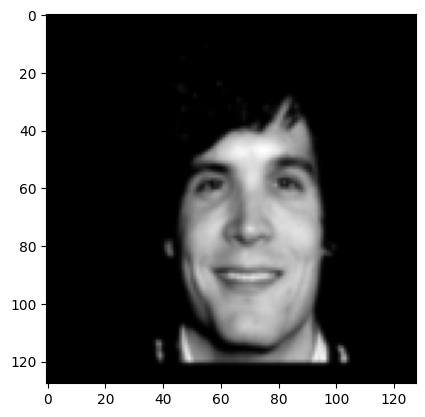

In [2]:
original_images = list()
for i in np.random.randint(1223,5222,3000): #Agregar de forma aleatoria las imagenes disponibles
    try:
        original_images.append(np.reshape(np.fromfile("rawdata/"+str(i),dtype=np.uint8),(128,128))) #Agregarlas si existe el directorio
    except:
        pass
print(len(original_images)) #Numero de imagenes de prueba
plt.imshow(original_images[5],cmap=cm.gray) #Mostrar alguna imagen

In [3]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(original_images):
    r, c = image.shape[0], image.shape[1]    
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
    
print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")


==> Least common image size: 128 x 128 pixels


In [4]:
def recenter(image, min_rows, min_cols):
    r, c = image.shape
    top, bot, left, right = 0, r, 0, c
    if r > min_rows:
        top = r - min_rows  
    if c > min_cols:
        right = min_cols     
    return image[top:bot, left:right]

In [5]:
test_img = list()
for img in original_images:
    test_img.append(recenter(img,min_rows,min_cols))
    
#X = list()
#for img in test_img:
#    X.append(img.flatten)

In [6]:
# Create m x d data matrix
m = len(test_img)
d = min_rows * min_cols
X = np.reshape(test_img, (m, d))

# Applying PCA

In [7]:
#Compute the SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Sanity check on dimensions
print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", S.shape)
print("V^T:", VT.shape)

X: (2990, 16384)
U: (2990, 2990)
Sigma: (2990,)
V^T: (2990, 16384)


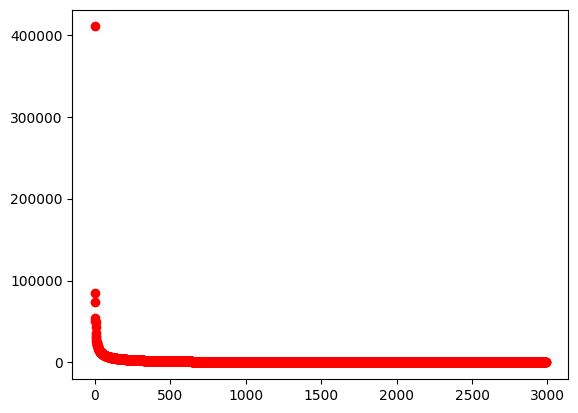

In [8]:
plt.plot(S, 'ro')

In [9]:
num_components = 5 # Number of principal components
Y = np.matmul(X, VT[:num_components,:].T)

## Computing eigenvectors

In [10]:
components = 100 #Numero de componentes a utilizar

means = X.mean(axis=0) #Media de los imagenes
print("mean shape: ",means.shape) #Tamaño del vector de la media (debe ser el numero de pixeles)

A = (X-means).T #Matriz A
print("A shape: ",A.shape) #Tamaño de la matriz A

mean shape:  (16384,)
A shape:  (16384, 2990)


In [11]:
A

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.0090301, -0.0090301, -0.0090301, ..., -0.0090301, -0.0090301,
        -0.0090301],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

In [12]:
M = A.T @ A #A transpuesta por A para obtener una matriz de MxM
print("At * A shape: ",M.shape) #Tamaño de la matriz At * A

At * A shape:  (2990, 2990)


In [63]:
mi, V = np.linalg.eig(M) #Obtener los eigenvectores y eigenvalores
mi = np.abs(mi) #Obtener la magnitud de los eigenvalores
print("V shape: ",V.shape) #Tamaño de la matriz de eigenvectores
print(mi.shape) #Tamaño de la matriz de eigenvalores

V shape:  (2990, 2990)
(2990,)


In [64]:
#Indices ordenados de forma descendente segun la magnitud de los eigenvalores
sorted_i = np.argsort(mi)
sorted_i = np.flip(sorted_i)

u = np.array([]) #Arreglo para guardar los eigenvectores de la matriz de covarianza
for i in sorted_i[:components]: #Para cada eigenvalor
    res = A @ V[:,i].T #Obtener el vector de la matriz de covarianza correspondiente al eigenvalor
    ui = res / np.linalg.norm(res) #Normalizar
    
    if len(u)==0: #Guardar el vector si la matriz esta vacia
        u = ui
    else: #Apilar el valor en la matriz de eigenvectores
        u = np.vstack((u,ui))

u = u.T
print(u.shape)

(16384, 100)


(100, 16384)


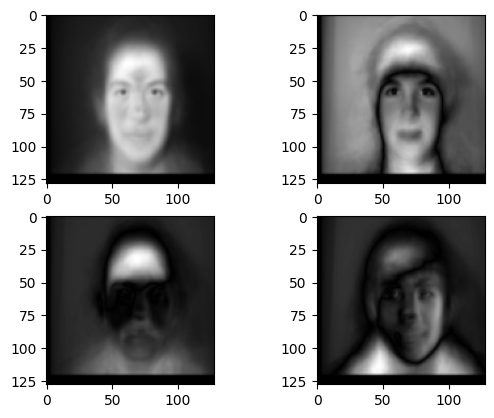

In [65]:
y = np.diag(mi[:components]) @ u.T #Eigenvectores mutliplicados por sus eigenvalores
print(y.shape)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(np.reshape(np.abs(y[0,:]),(128,128)),cmap=cm.gray) #Mostrar algunas de las caracteristicas mas significativas
axs[0, 1].imshow(np.reshape(np.abs(y[1,:]),(128,128)),cmap=cm.gray) #Mostrar algunas de las caracteristicas mas significativas
axs[1, 0].imshow(np.reshape(np.abs(y[2,:]),(128,128)),cmap=cm.gray) #Mostrar algunas de las caracteristicas mas significativas
axs[1, 1].imshow(np.reshape(np.abs(y[3,:]),(128,128)),cmap=cm.gray) #Mostrar algunas de las caracteristicas mas significativas

## Image Reconstruction

(16384,)


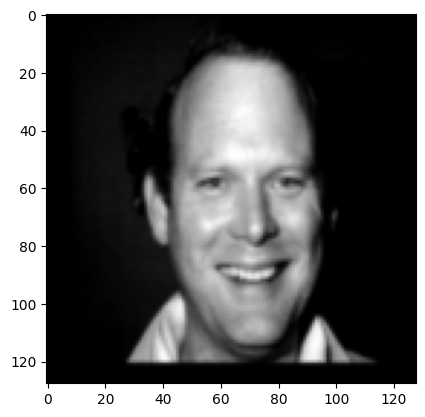

In [66]:
Timage = np.reshape(np.fromfile("rawdata/4877",dtype=np.uint8),(128,128)) #Imagen de prueba 1, de los datos de prueba en /rawdata

Timage2 = Image.open("test.jpg").convert("L") #Imagen de prueba 2
Timage2 = Timage2.resize((128,128))

Timage = recenter(np.array(Timage),min_rows,min_cols) #Recentrar la imagen
Timage2 = recenter(np.array(Timage2),min_rows,min_cols) #Recentrar la imagen

plt.imshow(Timage,cmap=cm.gray) #Mostrar la imagen de prueba 1
x1 = Timage.flatten() #Imagen en forma de vector de una dimension
x2 = Timage2.flatten() #Imagen en forma de vector de una dimension

print(x1.shape)

In [67]:
k = range(0,components,1) #Numero de valores caracteristicos a tomar para la prueba

### Prueba 1

(181.96889632107025+0j)
(272.9724572303544+0j)
(273.8798748217522+0j)
(284.8544536591639+0j)
(289.3820248625987+0j)
(289.30201204847225+0j)
(294.4255130948412+0j)
(286.68549798119346+0j)
(286.754172896069+0j)
(287.96945259771735+0j)
(271.64630685775444+0j)
(286.7784252314891+0j)
(294.99564985927947+0j)
(295.50548187087384+0j)
(298.973879218346+0j)
(309.0442883327699+0j)
(305.2845667986117+0j)
(306.48742672779304+0j)
(307.98163758722114+0j)
(315.15338126374866+0j)
(316.4477961405035+0j)
(316.4258516873175+0j)
(319.9487827675212+0j)
(320.80087219306915+0j)
(320.8465281911586+0j)
(320.96575112157+0j)
(318.55247132390616+0j)
(319.0623249233894+0j)
(323.47644821068445+0j)
(323.0320258598079+0j)
(326.5496023335046+0j)
(324.9276966380804+0j)
(321.49411436828+0j)
(321.4842568759777+0j)
(318.1965809827061+0j)
(320.4037888669208+0j)
(320.6699984454308+0j)
(320.8345551024221+0j)
(318.321569689366+0j)
(314.91373355033085+0j)
(315.33895613057695+0j)
(315.05471126936266+0j)
(316.3441337464379+0j)
(3

C:\Users\dark_\AppData\Local\Temp\ipykernel_19472\3117822482.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  resIm = Image.fromarray(reconstruct.astype(np.uint8)).convert("P")


(327.2027782420686+0j)
(330.01812962245134+0j)
(330.0503332515121+0j)
(330.76599308869703+0j)
(331.20077792820734+0j)
(331.596885561122+0j)
(331.0964556365336+0j)
(331.0996272991026+0j)
(331.3356466664062+0j)
(330.26292969217764+0j)
(330.42736286501963+0j)
(331.0861860937921+0j)
(331.70022528625293+0j)
(331.79506733644166+0j)
(331.2856628353043+0j)
(331.28819239923575+0j)
(330.9759305454394+0j)
(330.3875144615265+0j)
(330.44003196833387+0j)
(330.04643020703827+0j)
(329.98961647381736+0j)
(324.91446867781406+0j)
(324.4378479231285+0j)
(325.30062110255756+0j)


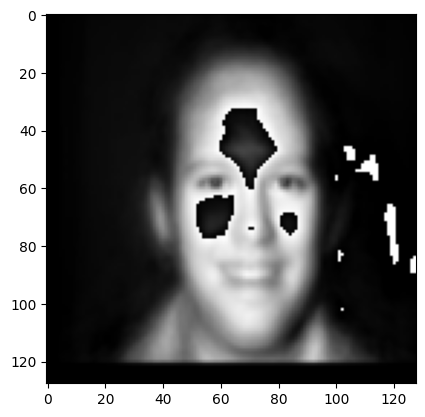

In [70]:
frames = [] #Arreglo para guardar la animacion
values, residuals, rank, singular = np.linalg.lstsq(u,x1,rcond=None) #Obtener los eigenvalores de la imagen segun los vectores caracteristicos

#Indices ordenados de forma descendente segun la magnitud de los eigenvalores
sorted = np.argsort(values)
sorted = np.flip(sorted_i)

#Para cada frame con un determinado numero de caracteristicas
for f in k:#sorted[:components]:
    reconstruct = u[:,:f] @ values[:f] #Multiplicar los eigenvectores por los valores caracteristicos
    reconstruct = np.reshape(reconstruct + means,(128,128)) #Reconstruir el vector en una imagen
    print(np.max(reconstruct))
    resIm = Image.fromarray(reconstruct.astype(np.uint8)).convert("P")
    plt.imshow(resIm)
    frames.append(resIm) #Agregar la imagen a la lista de frames
    #frames.append(reconstruct)

frames[0].save('res1.gif',
               save_all=True, append_images=frames[1:], optimize=False, duration=50, loop=0) #Guardar los frames en un gif

In [60]:
plt.imshow(frames[30],cmap=cm.gray)

IndexError: list index out of range

### Prueba 2

In [27]:
frames = [] #Arreglo para guardar la animacion
values, residuals, rank, singular = np.linalg.lstsq(u,x2,rcond=None) #Obtener los eigenvalores de la imagen segun los vectores caracteristicos
#Para cada frame con un determinado numero de caracteristicas
for f in k:
    reconstruct = u[:,:f] @ values[:f] #Multiplicar los eigenvectores por los valores caracteristicos
    reconstruct = np.reshape(reconstruct+means,(128,128)) #Reconstruir el vector en una imagen
    frames.append(Image.fromarray(reconstruct).convert("P")) #Agregar la imagen a la lista de frames

frames[0].save('res2.gif',
               save_all=True, append_images=frames[1:], optimize=False, duration=50, loop=0) #Guardar los frames en un gif

TypeError: Cannot handle this data type: (1, 1), <c16

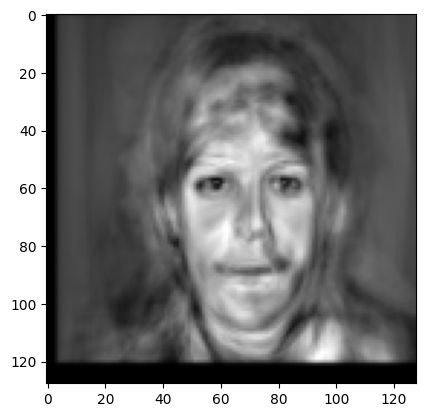

In [37]:
plt.imshow(frames[30],cmap=cm.gray)